# Assignment 8: DT

In [0]:
1.Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets
Set 1: categorical, numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF)
Set 2: categorical, numerical features + project_title(TFIDF W2V)+ preprocessed_eassay (TFIDF W2V)
2.The hyper paramter tuning (best depth in range [1, 5, 10, 50], and the best min_samples_split in range [5, 10, 100, 500])
Find the best hyper parameter which will give the maximum AUC value
find the best hyper paramter using k-fold cross validation(use gridsearch cv or randomsearch cv)/simple cross validation data(you can write your own for loops refer sample solution)
3.Representation of results
You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figurewith X-axis as min_sample_split, Y-axis as max_depth, and Z-axis as AUC Score , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive 3d_scatter_plot.ipynb
or


You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figureseaborn heat maps with rows as n_estimators, columns as max_depth, and values inside the cell representing AUC Score
You choose either of the plotting techniques out of 3d plot or heat map
Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
Along with plotting ROC curve, you need to print the confusion matrix with predicted and original labels of test data points
Once after you plot the confusion matrix with the test data, get all the false positive data points
Plot the WordCloud(https://www.geeksforgeeks.org/generating-word-cloud-python/) with the words of essay text of these false positive data points
Plot the box plot with the price of these false positive data points
Plot the pdf with the teacher_number_of_previously_posted_projects of these false positive data points

Task 2: For this task consider set-1 features. Select all the features which are having non-zero feature importance.You can get the feature importance using 'feature_importances_` (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), discard the all other remaining features and then apply any of the model of you choice i.e. (Dession tree, Logistic Regression, Linear SVM), you need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3
Note: when you want to find the feature importance make sure you don't use max_depth parameter keep it None.

You need to summarize the results at the end of the notebook, summarize it in the table format

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1OSWChyFHJhFlbFQod8Dn3Rr23CAEd2MR'}) # replace the id with id of file you want to access
downloaded.GetContentFile('preprocessed_data.csv') 

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

import plotly # import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

<h1>1. Decision Tree </h1>

## 1.1 Loading Data

In [139]:
import pandas
data = pandas.read_csv('preprocessed_data.csv')
data.head(1)

school_state  ...   price
0           ca  ...  725.05
1           ut  ...  213.03
2           ca  ...  329.00
3           ga  ...  481.04
4           wa  ...   17.74

[5 rows x 9 columns]

In [6]:
import pandas as pd
#data = pandas.read_csv('preprocessed_data.csv')
#data.head(5)
data  = pd.read_csv('preprocessed_data.csv',nrows=60000)
# data  = pd.read_csv('preprocessed_data.csv', nrows=60000) # you can take less number of rows like this
#data.head(5)
print(len(data))

60000


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [8]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)
#y.head()

school_state  ...   price
0           ca  ...  725.05

[1 rows x 8 columns]

In [9]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)
print(len(X_train))
print(len(X_test))
print(len(X_cv))


26934
19800
13266


In [10]:
data.columns.values

array(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects',
       'project_is_approved', 'clean_categories', 'clean_subcategories',
       'essay', 'price'], dtype=object)

## one hot vector for clean_categories

In [11]:
#one hot vector for clean_categories
vectorizer_clean_cat = CountVectorizer()
vectorizer_clean_cat.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_category_ohe = vectorizer_clean_cat.transform(X_train['clean_categories'].values)
X_cv_clean_category_ohe = vectorizer_clean_cat.transform(X_cv['clean_categories'].values)
X_test_clean_category_ohe = vectorizer_clean_cat.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_clean_category_ohe.shape, y_train.shape)
print(X_cv_clean_category_ohe.shape, y_cv.shape)
print(X_test_clean_category_ohe.shape, y_test.shape)
print(vectorizer_clean_cat.get_feature_names())
print("="*100)

After vectorizations
(26934, 9) (26934,)
(13266, 9) (13266,)
(19800, 9) (19800,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


## one hot vector for clean_subcategories

In [12]:
#one hot vector for clean_subcategories
vectorizer_clean_subcat = CountVectorizer()
vectorizer_clean_subcat.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcategory_ohe = vectorizer_clean_subcat.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcategory_ohe = vectorizer_clean_subcat.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcategory_ohe = vectorizer_clean_subcat.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_clean_subcategory_ohe.shape, y_train.shape)
print(X_cv_clean_subcategory_ohe.shape, y_cv.shape)
print(X_test_clean_subcategory_ohe.shape, y_test.shape)
print(vectorizer_clean_subcat.get_feature_names())
print("="*100)

After vectorizations
(26934, 30) (26934,)
(13266, 30) (13266,)
(19800, 30) (19800,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


## one hot vector for school_state

In [13]:
#one hot vector for school_state
vectorizer_school_state = CountVectorizer()
vectorizer_school_state.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_school_state_ohe = vectorizer_school_state.transform(X_train['school_state'].values)
X_cv_school_state_ohe =vectorizer_school_state.transform(X_cv['school_state'].values)
X_test_school_state_ohe = vectorizer_school_state.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_school_state_ohe.shape, y_train.shape)
print(X_cv_school_state_ohe.shape, y_cv.shape)
print(X_test_school_state_ohe.shape, y_test.shape)
print(vectorizer_school_state.get_feature_names())
print("="*100)

After vectorizations
(26934, 51) (26934,)
(13266, 51) (13266,)
(19800, 51) (19800,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


## one hot vector for vectorizer_project_grade

In [14]:
#one hot vector for vectorizer_project_grade
vectorizer_project_grade = CountVectorizer()
vectorizer_project_grade.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_grade_category_ohe = vectorizer_project_grade.transform(X_train['project_grade_category'].values)
X_cv_project_grade_category_ohe = vectorizer_project_grade.transform(X_cv['project_grade_category'].values)
X_test_project_grade_category_ohe = vectorizer_project_grade.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_project_grade_category_ohe.shape, y_train.shape)
print(X_cv_project_grade_category_ohe.shape, y_cv.shape)
print(X_test_project_grade_category_ohe.shape, y_test.shape)
print(vectorizer_project_grade.get_feature_names())
print("="*100)

After vectorizations
(26934, 4) (26934,)
(13266, 4) (13266,)
(19800, 4) (19800,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


## one hot vector for teacher_prefixs¶

In [15]:
#one hot vector for teacher_prefixs
vectorizer_teacher_prefixs = CountVectorizer()
vectorizer_teacher_prefixs.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_prefix_ohe = vectorizer_teacher_prefixs.transform(X_train['teacher_prefix'].values)
X_cv_teacher_prefix_ohe = vectorizer_teacher_prefixs.transform(X_cv['teacher_prefix'].values)
X_test_teacher_prefix_ohe =vectorizer_teacher_prefixs.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_prefix_ohe.shape, y_train.shape)
print(X_cv_teacher_prefix_ohe.shape, y_cv.shape)
print(X_test_teacher_prefix_ohe.shape, y_test.shape)
print(vectorizer_teacher_prefixs.get_feature_names())
print("="*100)

After vectorizations
(26934, 5) (26934,)
(13266, 5) (13266,)
(19800, 5) (19800,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


## vectorizing numerical data (previously_posted_projects)

In [16]:
from sklearn.preprocessing import Normalizer##http://localhost:8888/notebooks/Desktop/Machine%20learning/module-4/assignment-10/assignment-09/9_Assignment_DT_Instructions.ipynb#vectorizing-numerical-data-(previously_posted_projects)
normalizer_teacher_projects = Normalizer()
normalizer_teacher_projects.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_teacher_previously_posted_projects_norm = normalizer_teacher_projects.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_teacher_previously_posted_projects_norm = normalizer_teacher_projects.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teacher_previously_posted_projects_norm = normalizer_teacher_projects.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_teacher_previously_posted_projects_norm.shape, y_train.shape)
print(X_cv_teacher_previously_posted_projects_norm.shape, y_cv.shape)
print(X_test_teacher_previously_posted_projects_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(26934, 1) (26934,)
(13266, 1) (13266,)
(19800, 1) (19800,)


## Reshaping a numerical data

In [0]:
price_train = (X_train['price'].values.reshape(-1,1))
price_cv = (X_cv['price'].values.reshape(-1,1))
price_test = (X_test['price'].values.reshape(-1,1))


previous_projects_train = (X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
previous_projects_cv = (X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
previous_projects_test = (X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


# vectorizing text data

## 1.vectorizing preprocessed_essay (tfidf)


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer_tfidf_essay =TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_tfidf_essay.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer_tfidf_essay.transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer_tfidf_essay.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer_tfidf_essay.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)



print("NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME")


(26934, 8) (26934,)
(13266, 8) (13266,)
(19800, 8) (19800,)
After vectorizations
(26934, 5000) (26934,)
(13266, 5000) (13266,)
(19800, 5000) (19800,)
NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME


## Creating(set 1)

## Combining all the features using hstack

In [19]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_tfidf = hstack((X_train_clean_category_ohe, X_train_clean_subcategory_ohe,X_train_school_state_ohe, X_train_project_grade_category_ohe, X_train_teacher_prefix_ohe,X_train_essay_tfidf,price_train,previous_projects_train)).tocsr()
X_cv_tfidf = hstack((X_cv_clean_category_ohe, X_cv_clean_subcategory_ohe,X_cv_school_state_ohe, X_cv_project_grade_category_ohe, X_cv_teacher_prefix_ohe,X_cv_essay_tfidf,price_cv,previous_projects_cv)).tocsr()
X_te_tfidf = hstack((X_test_clean_category_ohe, X_test_clean_subcategory_ohe,X_test_school_state_ohe, X_test_project_grade_category_ohe,X_test_teacher_prefix_ohe,X_test_essay_tfidf,price_test,previous_projects_test)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_te_tfidf.shape, y_test.shape)
print("="*100)

Final Data matrix
(26934, 5101) (26934,)
(13266, 5101) (13266,)
(19800, 5101) (19800,)


In [0]:
# Necessary Package imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV


## Hyperparameter tuning 


In [0]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [0]:
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#parameters = {'max_depth':[1, 5, 10, 50],'min_samples_split':[5, 10, 100, 500]}
depth=[1, 5, 10, 50]
min_samples_split=[5, 10, 100, 500]
train_auc = [[0 for samples in min_samples_split]for max_depth in depth]
cv_auc = [[0 for samples in min_samples_split]for max_depth in depth]
i=0
for max_depth in depth:
    j = 0
    for samples in min_samples_split:
        clf_tfidf = DecisionTreeClassifier(max_depth = max_depth,min_samples_split=samples)
        clf_tfidf.fit(X_tr_tfidf, y_train)

        y_train_pred = batch_predict(clf_tfidf, X_tr_tfidf)    
        y_cv_pred = batch_predict(clf_tfidf, X_cv_tfidf)
        
        train_auc[i][j] = roc_auc_score(y_train,y_train_pred)
        cv_auc[i][j] = roc_auc_score(y_cv, y_cv_pred)
        j += 1
    i += 1

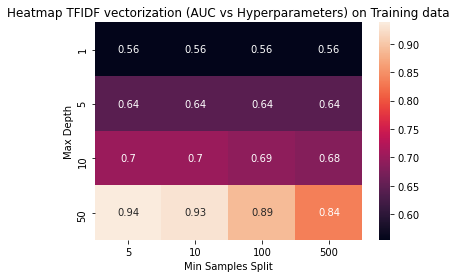

In [37]:
sns.heatmap(train_auc,annot=True,xticklabels=min_samples_split,yticklabels=depth)
plt.title('Heatmap TFIDF vectorization (AUC vs Hyperparameters) on Training data')
plt.ylabel('Max Depth')
plt.xlabel('Min Samples Split')A
plt.show()

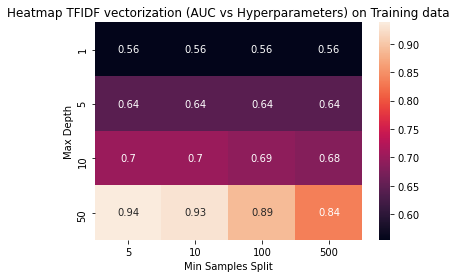

In [38]:
sns.heatmap(train_auc,annot=True,xticklabels=min_samples_split,yticklabels=depth)
plt.title('Heatmap TFIDF vectorization (AUC vs Hyperparameters) on Training data')
plt.ylabel('Max Depth')
plt.xlabel('Min Samples Split')
plt.show()

## Training the model on best hyperparamets and testing in Test set

In [0]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score

clf1 = DecisionTreeClassifier(max_depth = 10,min_samples_split=500)
clf1.fit(X_tr_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf1, X_tr_tfidf)    
y_test_pred = batch_predict(clf1, X_te_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#y_test_class = list(map(lambda x:1 if x>=0.5 else 0, y_test_pred))
#tn, fp, fn, tp = confusion_matrix(y_test, y_test_class).ravel()
#print('Confusion Matrix')
##print('================')
#print(np.array([[tn, tp],[fn, fp]]))
#print('Accuracy Score: ',accuracy_score(y_test, y_test_class))

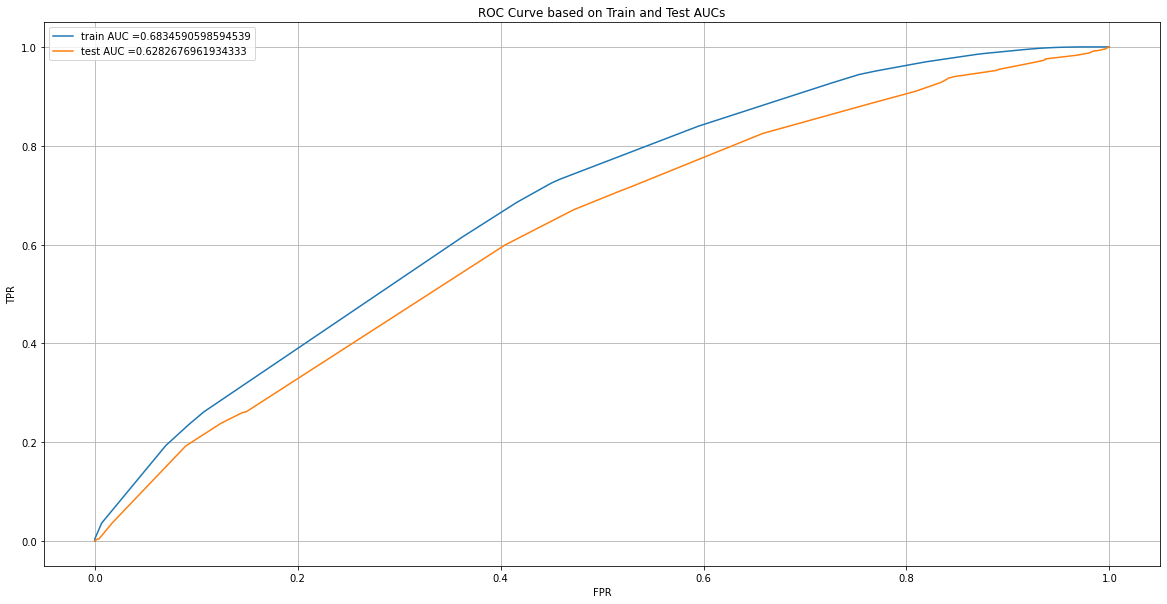

In [43]:
plt.figure(figsize=(20,10))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve based on Train and Test AUCs")
plt.grid()
plt.show()


## Confusion matrix for both train and test set data

In [0]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    global _predictions
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    _predictions = predictions
    return predictions

In [45]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
Train_CM = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_CM = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
print("Train confusion matrix")
print(Train_CM)
print("Test confusion matrix")
print(Test_CM)

the maximum value of tpr*(1-fpr) 0.40031786592122537 for threshold 0.874
Train confusion matrix
[[ 2499  1781]
 [ 7122 15532]]
Test confusion matrix
[[ 1662  1485]
 [ 5489 11164]]


Text(0.5, 1.0, 'Training Confusion Matrix')

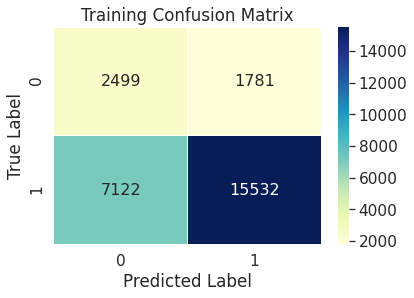

In [46]:
sns.set(font_scale=1.4)
sns.heatmap(Train_CM,annot=True,cbar=True,fmt="g", annot_kws = {"size":16},linewidths=.5,cmap="YlGnBu")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Training Confusion Matrix')

Text(0.5, 1.0, 'Testing Confusion Matrix')

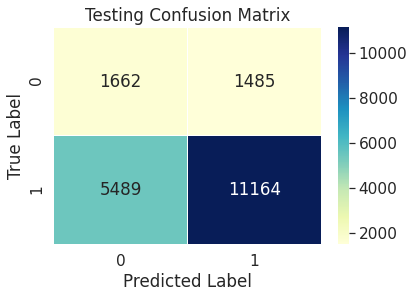

In [47]:
sns.heatmap(Test_CM,annot=True,cbar=True,fmt="d", linewidths=.5,cmap="YlGnBu")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Testing Confusion Matrix')

## **Extracting  features to draw decision tree**

In [50]:
feature_names_tfidf =[]
feature_names_tfidf.extend(vectorizer_clean_cat.get_feature_names())
feature_names_tfidf.extend(vectorizer_clean_subcat.get_feature_names())
feature_names_tfidf.extend(vectorizer_school_state.get_feature_names())
feature_names_tfidf.extend(vectorizer_project_grade.get_feature_names())
feature_names_tfidf.extend(vectorizer_teacher_prefixs.get_feature_names())
print(len(feature_names_tfidf))

99


In [51]:
feature_names_tfidf.extend(["price","teacher_previously_posted_projects",
                           ])
print(len(feature_names_tfidf))

101


In [52]:
k = (vectorizer_tfidf_essay.get_feature_names())
feature_names_tfidf.extend(k)
print(len(feature_names_tfidf))

5101


**Drawing** **decision** **tree**

In [0]:
#Please write all the code with proper documentation
dtree = DecisionTreeClassifier(max_depth=3)
clf = dtree.fit(X_tr_tfidf,y_train)
import graphviz
from sklearn import tree
from graphviz import Source
from sklearn.tree import export_graphviz
import pydot

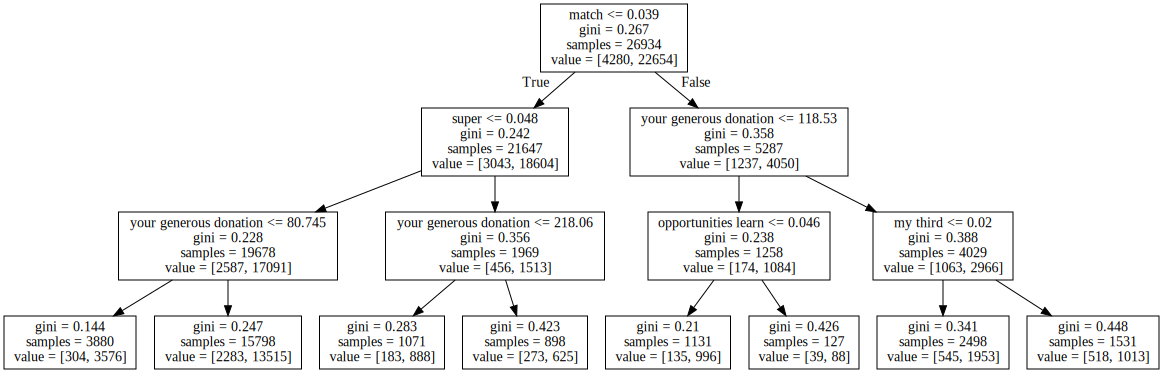

In [59]:
_dot_data = tree.export_graphviz(dtree, feature_names=feature_names_tfidf)
graph = graphviz.Source(_dot_data)
graph
#graph = Source(_dot_data)
#graph.render("tfidf of Words Tree", view=True)

## plotting word cloud

In [60]:
X_test['essay'].values[2]

'today ell kindergartners stem school tomorrow scientists technologists engineers mathematicians to become future professionals need develop practice strong academic skills need supplies build skills my kindergartners diverse energetic group 5 6 year olds southern arizona title i stem school 99 free lunch 1 2 refugees africa asia middle east all come low income households living neighborhood apartments trailer parks a lot parents want help children learn not always know these games activities give starting point the activities students make also supports common core standards gives students support need prepare become grade level ready i requesting laminating pouches ink paper play doh sheet protectors make activities students take home practice kindergarten skills they help make various math alphabet sight word games play maintain remediate skills working school practicing skills home serves strong enrichment tool ell students the play doh used practice letters numbers sight words bat

In [0]:
false_pos_indices = []
for i in range(len(y_test)):
    if(y_test[i]==0 and _predictions[i] == 1):
        false_pos_indices.append(i)
#In [180]:
false_pos_essay = []
for i in false_pos_indices :
    false_pos_essay.append(X_test['essay'].values[i])

In [0]:
from wordcloud import WordCloud, STOPWORDS
comments = " "
stopwords = set(STOPWORDS)
for _essay in false_pos_essay:
    tokens = str(_essay).lower().split()

for words in tokens:
    comments += words + " "
    
wordcloud = WordCloud(width=1000, height=1000, background_color="white",stopwords=stopwords, min_font_size=12).generate(comments)

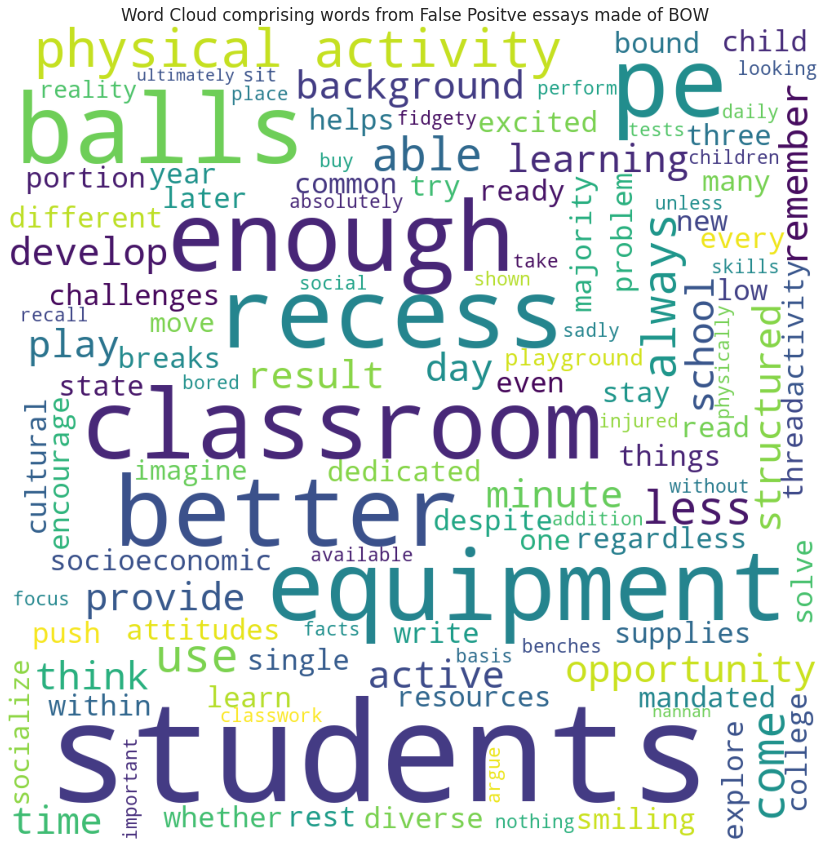

In [63]:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud comprising words from False Positve essays made of BOW")
plt.show()

**box** **plot** **with** **the** **price** **of** **these** **false** **positive** **data** **points**

In [64]:
cols = X_test.columns
X_test_falsePos = pd.DataFrame(columns=cols)
for i in false_pos_indices:
    X_test_falsePos = X_test_falsePos.append(X_test.filter(items=[i],axis=0))
    
X_test_falsePos.head(1)

school_state  ...   price
23           va  ...  279.98

[1 rows x 8 columns]

In [65]:
len(X_test_falsePos)

514

Text(0.5, 1.0, "Box Plot 'Price' v/s 'FP Data'")

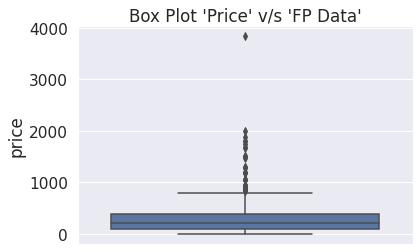

In [66]:
sns.boxplot(y="price",data=X_test_falsePos).set_title("Box Plot 'Price' v/s 'FP Data'")

# Drawing pdf with the teacher_number_of_previously_posted_projects of these false positive data points

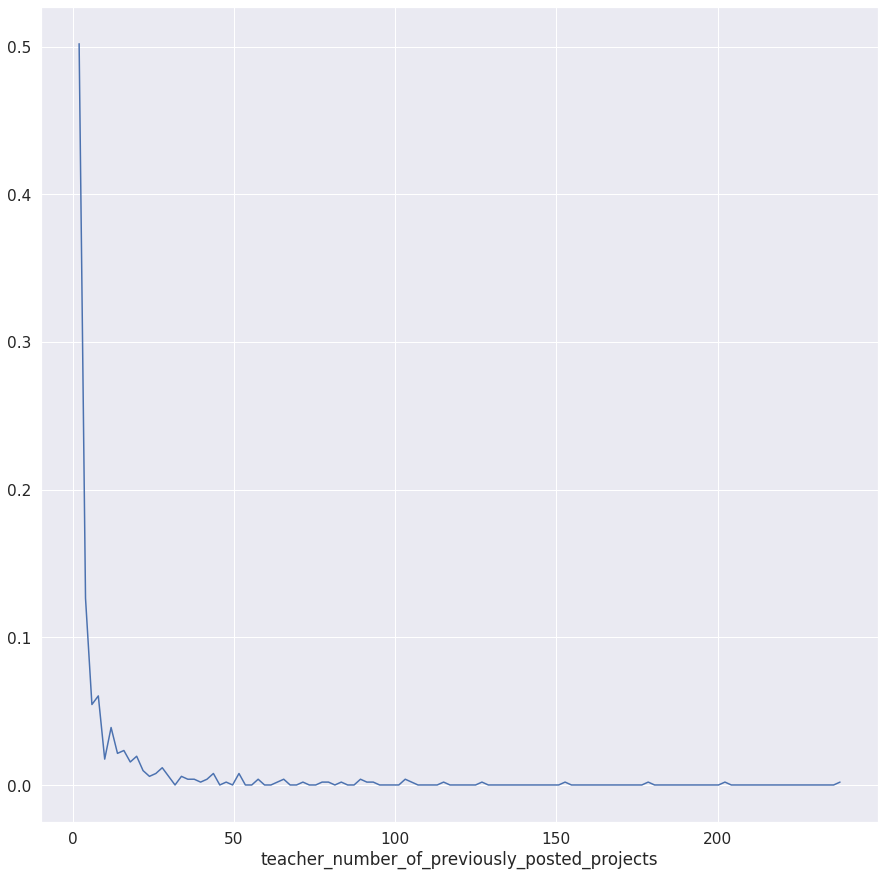

In [67]:
# Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`
plt.figure(figsize=(15,15))
counts, bin_edges = np.histogram(X_test_falsePos["teacher_number_of_previously_posted_projects"], bins="auto",density=True)
pdf = counts/sum(counts)
pdfPoints = plt.plot(bin_edges[1:],pdf)
plt.xlabel("teacher_number_of_previously_posted_projects")
plt.show()

## Creating (set-2)

### Applying tfidf w2vec

In [72]:
#tfidf_w2v train
from tqdm import tqdm
tfidf_w2v_vectors_train = [];# the avg-w2v for each sentence/review is stored in this list
glove_vectors = []
for sentence in tqdm(X_train["essay"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_vectors) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(Asentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
#(len(tfidf_w2v_vectors_train[0]))
#k = list('tfidf_w2v_vectors_train[0]')
#print(len(k))
#print(type(k))



100%|██████████| 26934/26934 [00:00<00:00, 41452.17it/s]

26934


In [73]:
#tfidf w2v
from tqdm import tqdm
tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
glove_vectors = []
for sentence in tqdm(X_cv["essay"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_vectors) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))

100%|██████████| 13266/13266 [00:00<00:00, 39302.13it/s]

13266


In [74]:
tfidf_w2v_vectors_test = []; 

for sentence in tqdm(X_test["essay"]): # for each review/sentence
    glove_vectors = []
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_vectors) and (word in tfidf_title_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

#print(len(tfidf_w2v_vectors_titles_test))

100%|██████████| 19800/19800 [00:00<00:00, 42131.18it/s]


In [76]:
from scipy.sparse import hstack
X_tr_tfidf_w2v = hstack((X_train_clean_category_ohe, X_train_clean_subcategory_ohe,X_train_school_state_ohe, X_train_project_grade_category_ohe, X_train_teacher_prefix_ohe,tfidf_w2v_vectors_train,price_train,previous_projects_train)).tocsr()
X_cv_tfidf_w2v = hstack((X_cv_clean_category_ohe, X_cv_clean_subcategory_ohe,X_cv_school_state_ohe, X_cv_project_grade_category_ohe, X_cv_teacher_prefix_ohe,tfidf_w2v_vectors_cv,price_cv,previous_projects_cv)).tocsr()
X_te_tfidf_w2v = hstack((X_test_clean_category_ohe, X_test_clean_subcategory_ohe,X_test_school_state_ohe, X_test_project_grade_category_ohe,X_test_teacher_prefix_ohe,tfidf_w2v_vectors_test,price_test,previous_projects_test)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf_w2v.shape, y_train.shape)
print(X_cv_tfidf_w2v.shape, y_cv.shape)
print(X_te_tfidf_w2v.shape, y_test.shape)
print("="*100)

Final Data matrix
(26934, 401) (26934,)
(13266, 401) (13266,)
(19800, 401) (19800,)


In [0]:
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#parameters = {'max_depth':[1, 5, 10, 50],'min_samples_split':[5, 10, 100, 500]}
depth=[1, 5, 10, 50]
min_samples_split=[5, 10, 100, 500]
train_auc = [[0 for samples in min_samples_split]for max_depth in depth]
cv_auc = [[0 for samples in min_samples_split]for max_depth in depth]
i=0
for max_depth in depth:
    j = 0
    for samples in min_samples_split:
        clf_tfidf = DecisionTreeClassifier(max_depth = max_depth,min_samples_split=samples)
        clf_tfidf.fit(X_tr_tfidf_w2v, y_train)

        y_train_pred = batch_predict(clf_tfidf, X_tr_tfidf_w2v)    
        y_cv_pred = batch_predict(clf_tfidf, X_cv_tfidf_w2v)
        
        train_auc[i][j] = roc_auc_score(y_train,y_train_pred)
        cv_auc[i][j] = roc_auc_score(y_cv, y_cv_pred)
        j += 1
    i += 1

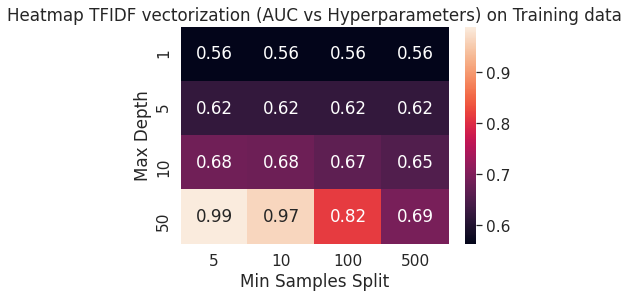

In [80]:
sns.heatmap(train_auc,annot=True,xticklabels=min_samples_split,yticklabels=depth)
plt.title('Heatmap TFIDF vectorization (AUC vs Hyperparameters) on Training data')
plt.ylabel('Max Depth')
plt.xlabel('Min Samples Split')
plt.show()

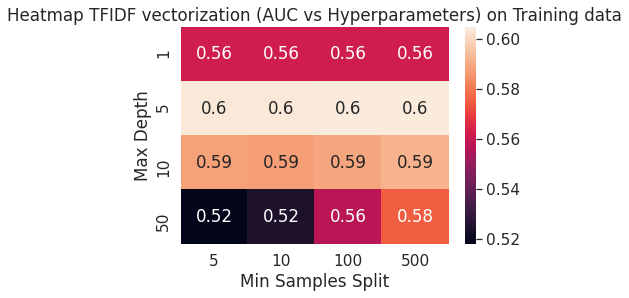

In [81]:
sns.heatmap(cv_auc,annot=True,xticklabels=min_samples_split,yticklabels=depth)
plt.title('Heatmap TFIDF vectorization (AUC vs Hyperparameters) on Training data')
plt.ylabel('Max Depth')
plt.xlabel('Min Samples Split')
plt.show()

In [0]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score

clf1 = DecisionTreeClassifier(max_depth = 5,min_samples_split=500)
clf1.fit(X_tr_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf1, X_tr_tfidf)    
y_test_pred = batch_predict(clf1, X_te_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)



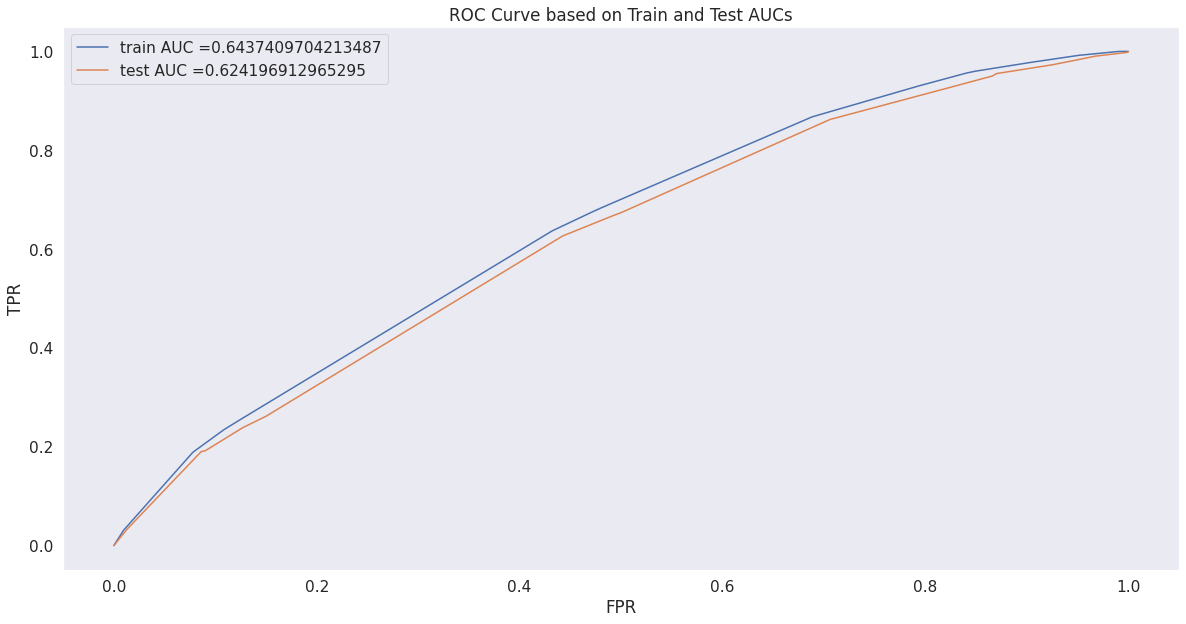

In [98]:
plt.figure(figsize=(20,10))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve based on Train and Test AUCs")
plt.grid()
plt.show()


In [85]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
Train_CM = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_CM = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
print("Train confusion matrix")
print(Train_CM)
print("Test confusion matrix")
print(Test_CM)

the maximum value of tpr*(1-fpr) 0.39957561496020183 for threshold 0.874
Train confusion matrix
[[ 2500  1780]
 [ 7157 15497]]
Test confusion matrix
[[ 1670  1477]
 [ 5500 11153]]


Text(0.5, 1.0, 'Training Confusion Matrix')

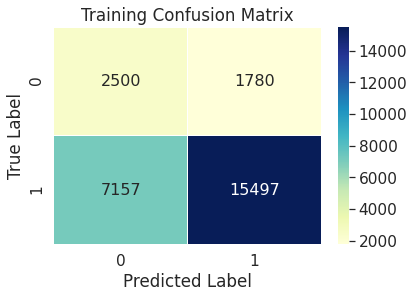

In [86]:
sns.set(font_scale=1.4)
sns.heatmap(Train_CM,annot=True,cbar=True,fmt="g", annot_kws = {"size":16},linewidths=.5,cmap="YlGnBu")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Training Confusion Matrix')

Text(0.5, 1.0, 'Testing Confusion Matrix')

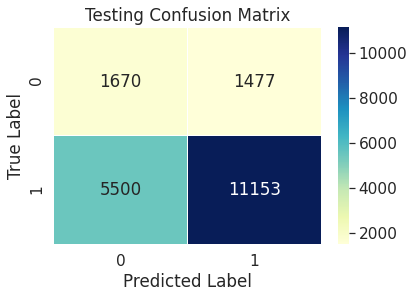

In [87]:
sns.heatmap(Test_CM,annot=True,cbar=True,fmt="d", linewidths=.5,cmap="YlGnBu")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Testing Confusion Matrix')

In [145]:
X_test['essay'].values[3]

'if not struggling not learning quote past student our school title 1 school many students not opportunities many students in spite financial challenges face many community children amazing work hard accomplish goals available they continuously prove no limit achievements reach given support need i made switch desks tables classroom loving it enabling much group discussions collaborative projects in order students get experience typing computers research i wanting chromebook table group our school provides two i wanting add four technological competence skill students today absolutely need by giving students opportunities utilize technology available chromebooks help keep skills need become successful citizens nannan'

In [0]:
false_pos_indices = []
for i in range(len(y_test)):
    if(y_test[i]==0 and _predictions[i] == 1):
        false_pos_indices.append(i)
#In [180]:
false_pos_essay = []
for i in false_pos_indices :
    false_pos_essay.append(X_test['essay'].values[i])

In [0]:
from wordcloud import WordCloud, STOPWORDS
comments = " "
stopwords = set(STOPWORDS)
for _essay in false_pos_essay:
    tokens = str(_essay).lower().split()

for words in tokens:
    comments += words + " "
    
wordcloud = WordCloud(width=1000, height=1000, background_color="white",stopwords=stopwords, min_font_size=12).generate(comments)

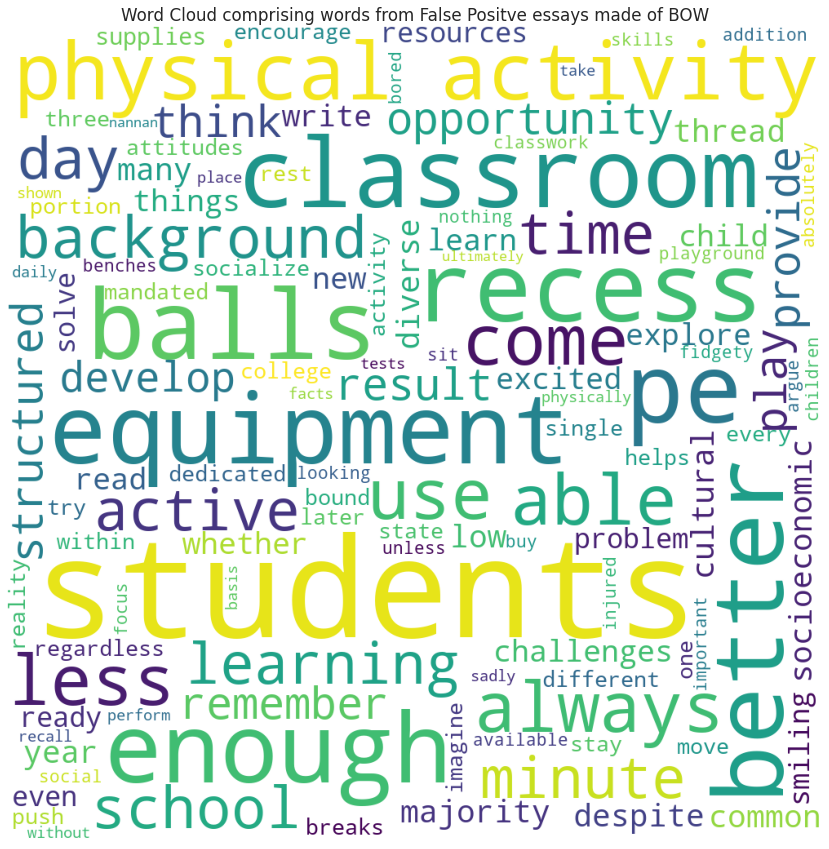

In [91]:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud comprising words from False Positve essays made of BOW")
plt.show()

In [92]:
cols = X_test.columns
X_test_falsePos = pd.DataFrame(columns=cols)
for i in false_pos_indices:
    X_test_falsePos = X_test_falsePos.append(X_test.filter(items=[i],axis=0))
    
X_test_falsePos.head(1)

school_state  ...   price
23           va  ...  279.98

[1 rows x 8 columns]

In [93]:
len(X_test_falsePos)

508

Text(0.5, 1.0, "Box Plot 'Price' v/s 'FP Data'")

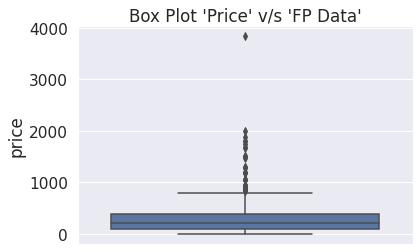

In [94]:
sns.boxplot(y="price",data=X_test_falsePos).set_title("Box Plot 'Price' v/s 'FP Data'")

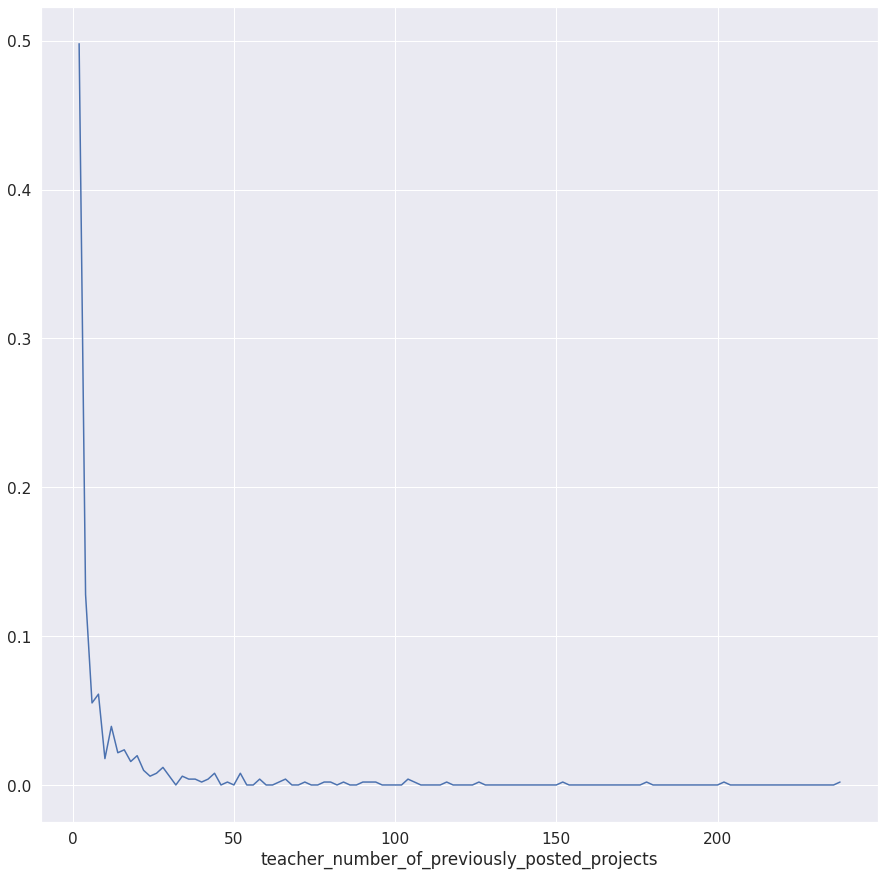

In [95]:
#Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`
plt.figure(figsize=(15,15))
counts, bin_edges = np.histogram(X_test_falsePos["teacher_number_of_previously_posted_projects"], bins="auto",density=True)
pdf = counts/sum(counts)
pdfPoints = plt.plot(bin_edges[1:],pdf)
plt.xlabel("teacher_number_of_previously_posted_projects")
plt.show()

# Task - 2 (selecting top features)

# selcting top 5k data features from tfidf

In [104]:
task2_clf_set1 = DecisionTreeClassifier(min_samples_split= 500)

task2_clf_set1.fit(X_tr_tfidf, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [109]:
nonzero_features = np.nonzero(task2_clf_set1.feature_importances_)[0]
#print(nonzero_features)
print(len(nonzero_features))

942


In [111]:
from sklearn.linear_model import LogisticRegression

X_tr_nonzero_set1 = X_tr_tfidf[:, nonzero_features]
X_te_nonzero_set1 = X_te_tfidf[:, nonzero_features]
print(X_tr_nonzero_set1.shape,y_train.shape)
print(X_te_nonzero_set1.shape,y_train.shape)
param = {'C': [0.001, 1, 100]}

clf_LR = LogisticRegression()

grid_search = GridSearchCV(clf_LR, param_grid = param)
grid_search.fit(X_tr_nonzero_set1, y_train)


(26934, 942) (26934,)
(19800, 942) (26934,)


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None, param_grid={'C': [0.001, 1, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [112]:
grid_search.best_params_

{'C': 1}

In [113]:
LR_clf_set1 = LogisticRegression(C= grid_search.best_params_['C'])

LR_clf_set1.fit(X_tr_nonzero_set1, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_train_pred = LR_clf_set1.predict_proba(X_tr_nonzero_set1)[:,1] 
y_test_pred = LR_clf_set1.predict_proba(X_te_nonzero_set1)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

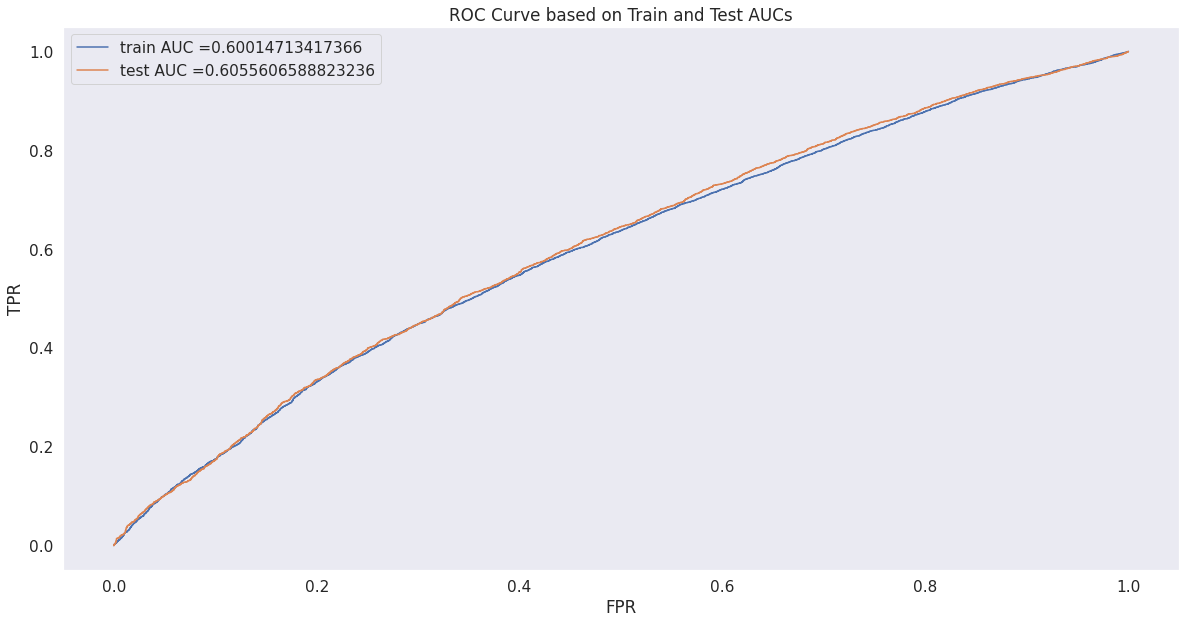

In [121]:
plt.figure(figsize=(20,10))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve based on Train and Test AUCs")
plt.grid()
plt.show()

In [0]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    global _predictions
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    _predictions = predictions
    return predictions

In [126]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
Train_CM = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
Test_CM = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
print("Train confusion matrix")
print(Train_CM)
print("Test confusion matrix")
print(Test_CM)

the maximum value of tpr*(1-fpr) 0.33061723332472487 for threshold 0.841
Train confusion matrix
[[ 2516  1764]
 [ 9913 12741]]
Test confusion matrix
[[1867 1280]
 [7284 9369]]


Text(0.5, 1.0, 'Training Confusion Matrix')

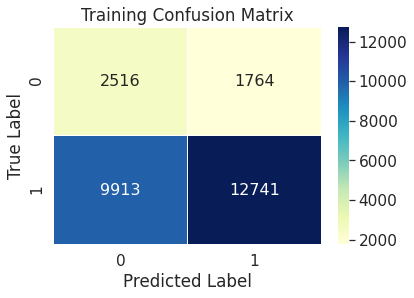

In [128]:
sns.set(font_scale=1.4)
sns.heatmap(Train_CM,annot=True,cbar=True,fmt="g", annot_kws = {"size":16},linewidths=.5,cmap="YlGnBu")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Training Confusion Matrix')

Text(0.5, 1.0, 'Testing Confusion Matrix')

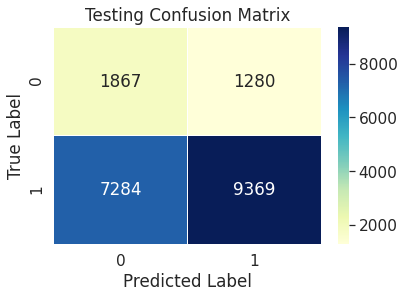

In [129]:
sns.heatmap(Test_CM,annot=True,cbar=True,fmt="d", linewidths=.5,cmap="YlGnBu")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Testing Confusion Matrix')

In [0]:
false_pos_indices = []
for i in range(len(y_test)):
    if(y_test[i]==0 and _predictions[i] == 1):
        false_pos_indices.append(i)
#In [180]:
false_pos_essay = []
for i in false_pos_indices :
    false_pos_essay.append(X_test['essay'].values[i])

In [0]:
from wordcloud import WordCloud, STOPWORDS
comments = " "
stopwords = set(STOPWORDS)
for _essay in false_pos_essay:
    tokens = str(_essay).lower().split()

for words in tokens:
    comments += words + " "
    
wordcloud = WordCloud(width=1000, height=1000, background_color="white",stopwords=stopwords, min_font_size=12).generate(comments)

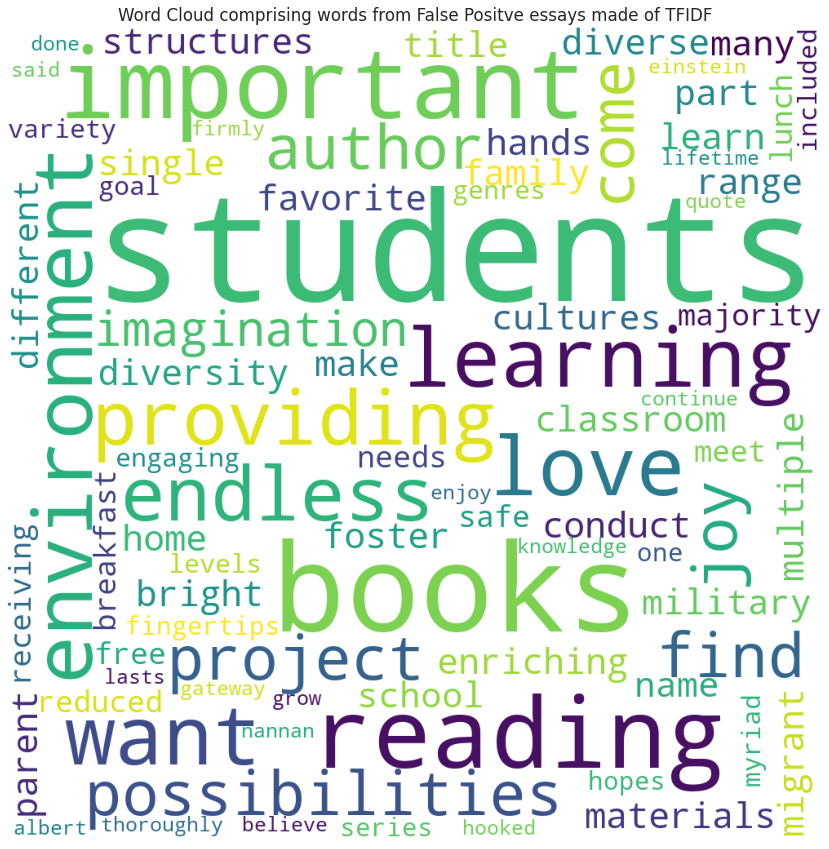

In [136]:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud comprising words from False Positve essays made of TFIDF")
plt.show()

In [137]:
cols = X_test.columns
X_test_falsePos = pd.DataFrame(columns=cols)
for i in false_pos_indices:
    X_test_falsePos = X_test_falsePos.append(X_test.filter(items=[i],axis=0))
    
X_test_falsePos.head(1)

school_state  ...   price
23           va  ...  279.98

[1 rows x 8 columns]

Text(0.5, 1.0, "Box Plot 'Price' v/s 'FP Data'")

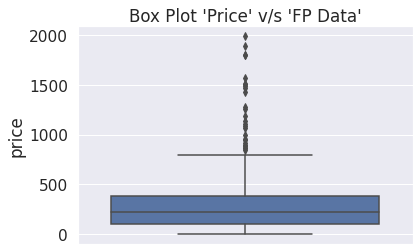

In [138]:
sns.boxplot(y="price",data=X_test_falsePos).set_title("Box Plot 'Price' v/s 'FP Data'")

**summary**

In [5]:
 #Please compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
TB = PrettyTable()
TB.field_names = ["Model", "Hyperparameter", "Train_AUC", "Test_Auc"]
TB.title = "Decision Tree"
TB.add_row(["TFIDF-Model", "Depth:10 | Samp_Split:500", 0.68, 0.62])
TB.add_row(["tfidf_W2v-Model", "Depth:5 | Samp_Split:500", 0.64, 0.62])

TB.add_row(["Logistic Reg on Best 5K","C:1.0  | Reg: L1", 0.60, 0.60])
print(TB)

+-------------------------+---------------------------+-----------+----------+
|          Model          |       Hyperparameter      | Train_AUC | Test_Auc |
+-------------------------+---------------------------+-----------+----------+
|       TFIDF-Model       | Depth:10 | Samp_Split:500 |    0.68   |   0.62   |
|     tfidf_W2v-Model     |  Depth:5 | Samp_Split:500 |    0.64   |   0.62   |
| Logistic Reg on Best 5K |      C:1.0  | Reg: L1     |    0.6    |   0.6    |
+-------------------------+---------------------------+-----------+----------+
